## Person Re-Identification Exploration Notebook with Triplet loss

This notebook is a beginning notebook for my exploration into person-reidentification. I am hoping to build on the notebook as I increase my knowlege and learn more.


In [1]:
#imports
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
import cv2
import torchvision.datasets as datasets
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML, Markdown
import os
import glob
from torch.utils.data import DataLoader , TensorDataset, Dataset,Subset,ConcatDataset
%matplotlib inline

In [2]:
to_pil = torchvision.transforms.ToPILImage()
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

class reID_dataset(Dataset):
    
    def __init__(self, root_dir,classes=30,transform=None,testing_data=True):
        self.classes = classes
        self.testing = testing_data
        self.root_dir = root_dir
        self.imageFolderDataset = datasets.ImageFolder(self.root_dir)    
        self.transform = transform
        self.label_choices = np.sort(os.listdir(root_dir))[:classes]
        self.data = 0
        
    def __len__(self):
        if self.testing:
            return 14000
        else:
            return 70000
        
    def __getpair__(self,idx):
        root_dir = self.root_dir
        label = np.random.choice(self.label_choices)
        rand_label = np.random.choice(self.label_choices)
        if rand_label == label:
            while True:
                rand_label = np.random.choice(self.label_choices)
                if rand_label != label:
                    break
                
        anchor = os.path.join(os.path.join(os.path.join(root_dir,label)),np.random.choice(os.listdir(os.path.join(os.path.join(root_dir,label)))))
        positive = os.path.join(os.path.join(os.path.join(root_dir,label)),np.random.choice(os.listdir(os.path.join(os.path.join(root_dir,label)))))
        negative = os.path.join(os.path.join(os.path.join(root_dir,rand_label)),np.random.choice(os.listdir(os.path.join(os.path.join(root_dir,rand_label)))))
        return anchor,positive,negative,label
                


    def __getitem__(self, idx):
        self.data += 1
        try:
            anchor_path,pos_path,neg_path,label =  self.__getpair__(idx)
            
            anchor = Image.open(anchor_path)
            positive = Image.open(pos_path)
            negative = Image.open(neg_path)
    #         img0 = img0.convert("L")
    #         img1 = img1.convert("L")

            if self.transform is not None:
                anchor = self.transform(anchor)
                positive = self.transform(positive)
                negative = self.transform(negative)
            
            return anchor,positive,negative,label
        except Exception as e:
            print(e)
            pass

In [4]:
train_dataset = reID_dataset(root_dir='/kaggle/input/person-reidentification/train',classes=10,transform=transforms.Compose([transforms.RandomRotation(10),transforms.ToTensor()]))
test_dataset = reID_dataset(root_dir='/kaggle/input/person-reidentification/test',classes=10,transform=transforms.Compose([transforms.RandomRotation(10),transforms.ToTensor()]))

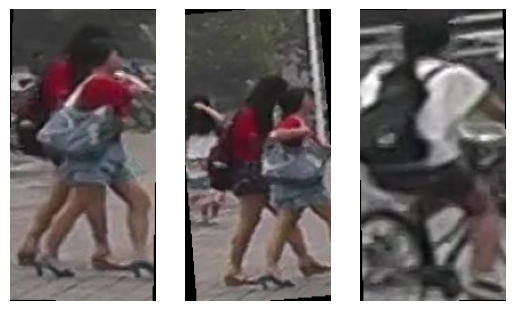

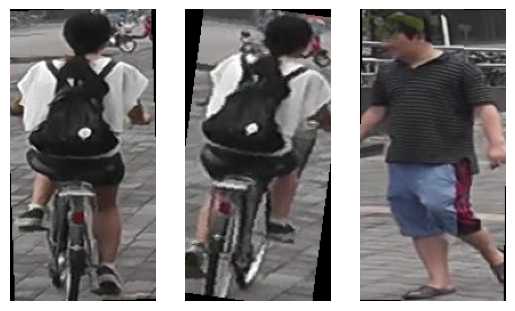

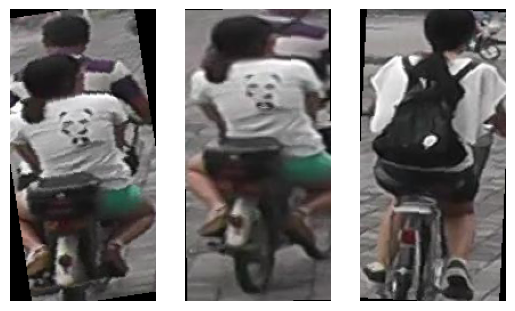

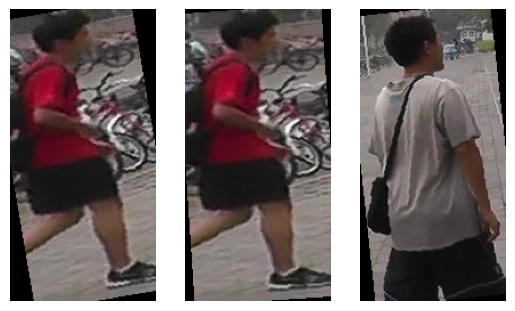

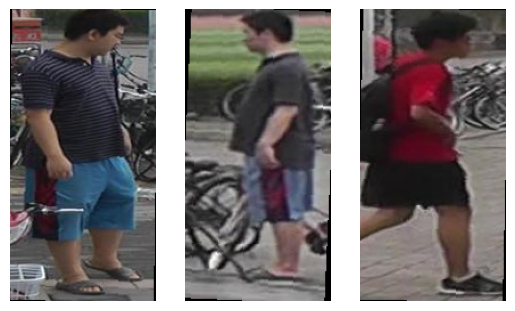

In [5]:

for i in np.random.randint(1,len(train_dataset),size=5):
    i1,i2,i3,label = train_dataset[i]
    fig = plt.figure()
    fig.add_subplot(1,3,1)
    plt.imshow(to_pil(i1))
    plt.axis('off')
    fig.add_subplot(1,3,2)
    plt.imshow(to_pil(i2))
    plt.axis('off')
    fig.add_subplot(1,3,3)
    plt.imshow(to_pil(i3))
    plt.axis('off')
    
    plt.show()


In [6]:
class triplet_model(nn.Module):
    def __init__(self,num_epochs=10,learning_rate=0.001):
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        super(triplet_model, self).__init__()
        self.cnn1 = nn.Sequential(
#             nn.ReflectionPad2d(1),
            nn.Conv2d(3, 64, kernel_size=3),
            nn.Dropout2d(0.8),
             nn.PReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(3, stride=2),
            
#             nn.ReflectionPad2d(1),
            nn.Conv2d(64, 32, kernel_size=3),
            nn.Dropout2d(0.6),
            nn.PReLU(),
            nn.BatchNorm2d(32),

#             nn.ReflectionPad2d(1),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.Dropout2d(0.5),
            nn.PReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(3, stride=2),
            
#             nn.ReflectionPad2d(1),
            nn.Conv2d(32, 16, kernel_size=3),
            nn.Dropout2d(0.5),
            nn.PReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(3, stride=2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(5376, 256),
            nn.Dropout(0.5),
            nn.PReLU(),

            nn.Linear(256, 128))

    def forward(self, x):
        output = self.cnn1(x)
        output = output.view(output.size(0), -1)
        output = self.fc1(output)
        return output

In [7]:
#refering to https://www.kaggle.com/code/hirotaka0122/triplet-loss-with-pytorch/notebook
class TripletLoss(nn.Module):
    def __init__(self, m=1.0):
        super(TripletLoss, self).__init__()
        self.margin = m
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        pos_dist =  (anchor - positive).pow(2).sum(1)
        neg_dist = (anchor - negative).pow(2).sum(1)
        loss = torch.relu(pos_dist - neg_dist + self.margin).mean()
        return loss

In [8]:
def fit(model,loss,train_data=None,validation_data=None,device=None,batch_size=32,num_epochs=10):
    training_loss_list, validation_loss_list = [],[]
    print('Training the model.........')
    optimizer = optim.Adam(model.parameters(), lr=model.learning_rate,weight_decay=0.007)
    model.train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

    model.validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size,
                                     shuffle=False, num_workers=2)

    for epoch in range(num_epochs):
        train_loss,validation_loss = [],[]
        loop = tqdm(model.train_loader)
        for idx,(anchor,positive,negative,_) in enumerate(loop):
            model.train()
            anchor,positive,negative =  anchor.cuda(),positive.cuda(),negative.cuda()
            optimizer.zero_grad()
            model = model.cuda()
            anchor_embedding = model(anchor)
            positive_embedding = model(positive)
            negative_embedding = model(negative)
            loss_val = loss(anchor_embedding,positive_embedding,negative_embedding)
            train_loss.append(loss_val.item())
            loss_val.backward()
            optimizer.step()
            if idx % 10 == 0:
                loop.set_postfix(
                    train_loss=loss_val.item(),
                )
        with torch.no_grad():
            for idx,(val_anchor,val_positive,val_negative,_) in enumerate(model.validation_loader):
                val_anchor,val_positive,val_negative = val_anchor.cuda(),val_positive.cuda(),val_negative.cuda()
                model.eval()
                val_anchor_embedding = model(val_anchor)
                val_positive_embedding = model(val_positive)
                val_negative_embedding = model(val_negative)
                val_loss = loss(val_anchor_embedding,val_positive_embedding,val_negative_embedding)
                validation_loss.append(val_loss.item())
        training_loss_list.append(np.mean(train_loss))
        validation_loss_list.append(np.mean(validation_loss))
        print("epoch : {}/{}, Training loss = {:.6f},Validation loss = {:.6f}".format(epoch + 1, model.num_epochs, np.mean(train_loss),
                                                                                                            np.mean(validation_loss)))
    
    return model,training_loss_list,validation_loss_list

In [9]:
model = triplet_model(num_epochs=10,learning_rate=0.0003).cuda()
loss = TripletLoss()
model,train_loss, validation_loss = fit(model,loss,num_epochs=10,train_data=train_dataset,validation_data=test_dataset,batch_size=64)

Training the model.........


  0%|          | 0/219 [00:00<?, ?it/s]

epoch : 1/10, Training loss = 5.547592,Validation loss = 0.794379


  0%|          | 0/219 [00:00<?, ?it/s]

epoch : 2/10, Training loss = 2.113649,Validation loss = 0.885816


  0%|          | 0/219 [00:00<?, ?it/s]

epoch : 3/10, Training loss = 1.417665,Validation loss = 0.852613


  0%|          | 0/219 [00:00<?, ?it/s]

epoch : 4/10, Training loss = 1.127582,Validation loss = 0.734850


  0%|          | 0/219 [00:00<?, ?it/s]

epoch : 5/10, Training loss = 1.007106,Validation loss = 0.706746


  0%|          | 0/219 [00:00<?, ?it/s]

epoch : 6/10, Training loss = 0.894028,Validation loss = 0.524048


  0%|          | 0/219 [00:00<?, ?it/s]

epoch : 7/10, Training loss = 0.818876,Validation loss = 0.506217


  0%|          | 0/219 [00:00<?, ?it/s]

epoch : 8/10, Training loss = 0.731856,Validation loss = 0.520197


  0%|          | 0/219 [00:00<?, ?it/s]

epoch : 9/10, Training loss = 0.680466,Validation loss = 0.495846


  0%|          | 0/219 [00:00<?, ?it/s]

epoch : 10/10, Training loss = 0.623288,Validation loss = 0.510499


In [10]:
def plot_train_validation_curve(model,training_loss_list,validation_loss_list):
    epochs = range(1, model.num_epochs+1)
    plt.plot(epochs, training_loss_list, label='Training Loss')
    plt.plot(epochs, validation_loss_list, label='Validation Loss')
    # plt.plot(epochs, testing_loss_list, label='Testing Loss')
    plt.title('Learning curve')
    plt.xlabel('Iteration')
    plt.ylabel('Learning Curve (Loss)')
    plt.xticks(np.arange(1,model.num_epochs+1, 1))
    plt.legend(loc='best')
    plt.show()
    pass


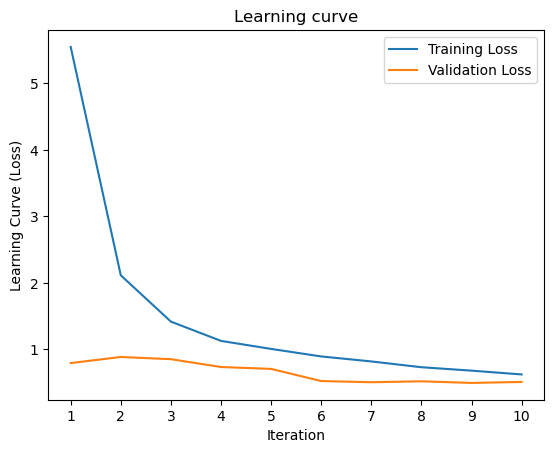

In [11]:
plot_train_validation_curve(model,train_loss,validation_loss)

In [12]:
def calc_euclidean(x1, x2):
    return (x1 - x2).pow(2).sum(1)

def NormalizeTensor(data1,data2,data3):
    min_val = min([torch.min(data1),torch.min(data2),torch.min(data3)])
    max_val = min([torch.max(data1),torch.max(data2),torch.max(data3)])
    data1 = (data1 - min_val) / (max_val - min_val)
    data2 = (data2 - min_val) / (max_val - min_val)
    data3 = (data3 - min_val) / (max_val - min_val)
    return data1,data2,data3

In [13]:
def predict_data(model,test_data,device=None,batch_size=64):
    print('Testing the model.........')
    test_dataloader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,
    shuffle=True, num_workers=2)
    loss = TripletLoss()
    actual,predicted = [],[]
    with torch.no_grad():
        for idx,(val_anchor,val_positive,val_negative,_) in enumerate(model.validation_loader):
            accuracy_list,testing_loss = [],[]
            val_anchor,val_positive,val_negative = val_anchor.cuda(),val_positive.cuda(),val_negative.cuda()
            model.eval()
            val_anchor_embedding = model(val_anchor)
            val_positive_embedding = model(val_positive)
            val_negative_embedding = model(val_negative)
            val_loss = loss(val_anchor_embedding,val_positive_embedding,val_negative_embedding)
            validation_loss.append(val_loss.item())
            a,p = [],[]
            for i in range(len(val_anchor)):
                anch_embedding = model(val_anchor[i].unsqueeze(0))
                pos_embedding = model(val_positive[i].unsqueeze(0))
                neg_embedding = model(val_negative[i].unsqueeze(0))
                predict_loss = loss(anch_embedding,pos_embedding,pos_embedding)
                testing_loss.append(predict_loss.item())
                d_func = nn.PairwiseDistance(p=2)
                pos_dist,neg_dist = d_func(anch_embedding,pos_embedding),d_func(anch_embedding,neg_embedding)
                a.append(0)
                if pos_dist <= neg_dist:
                    p.append(0)
                else:
                    p.append(1)
            predicted.append(p)
            actual.append(a)
            accuracy = round(((sum(np.array(p)==np.array(a)).item())/(len(np.array(a))))*100,3)
            accuracy_list.append(accuracy)
    print('Testing Accuracy = {:.3f}%, Testing Loss = {:.6f}'.format(np.mean(accuracy_list),np.mean(testing_loss)))
    return accuracy_list,testing_loss,np.concatenate(actual).ravel(),np.concatenate(predicted).ravel()


In [19]:
acc_list,testing_loss,actual,predicted = predict_data(model,test_data=test_dataset,device=device,batch_size=64)

Testing the model.........
Testing Accuracy = 93.750%, Testing Loss = 1.000000


In [28]:
def display_similar_images(model,test_img):
#     plt.title('Subject')
#     plt.imshow(to_pil(test_img))
#     plt.show()
    similar_imgs = []
    model = model.cuda()
    for idx,(val_anchor,val_positive,val_negative,_) in enumerate(model.validation_loader):
        for i in range(len(val_anchor)):
            search_img = model(test_img.cuda().unsqueeze(0))
            anchor = model(val_anchor[i].cuda().unsqueeze(0))
            d_func = nn.PairwiseDistance(p=2)
            dist = d_func(anchor,search_img)
            comparing_dist = d_func(search_img,search_img)
            if dist <= (0.1):
                similar_imgs.append(val_anchor[i])
            if len(similar_imgs) >= 100:
                break
    print(len(similar_imgs))
    plt.title('Test Subject')
    plt.imshow(to_pil(test_img))
    plt.axis('off')
    plt.show()
    
    fig = plt.figure()
    fig.add_subplot(1,4,1)
    plt.title('Predicted Similar Subjects')
    plt.imshow(to_pil(similar_imgs[0]))
    plt.axis('off')
    fig.add_subplot(1,4,2)
    plt.imshow(to_pil(similar_imgs[1]))
    plt.axis('off')
    fig.add_subplot(1,4,3)
    plt.imshow(to_pil(similar_imgs[2]))
    plt.axis('off')
    fig.add_subplot(1,4,4)
    plt.imshow(to_pil(similar_imgs[3]))
    plt.axis('off')
    plt.show()
    pass


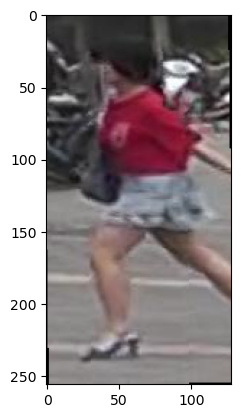

In [24]:
test_img,_,_,_ = test_dataset[0]
plt.imshow(to_pil(test_img))
plt.show()

110


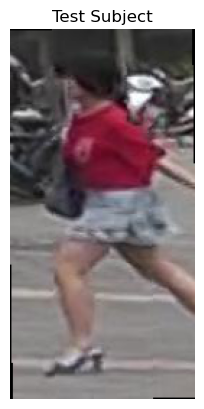

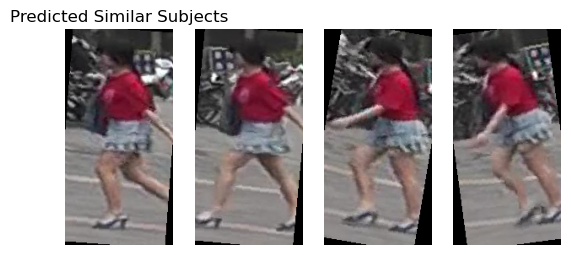

In [25]:
display_similar_images(model,test_img)

In [26]:
del train_dataset

100


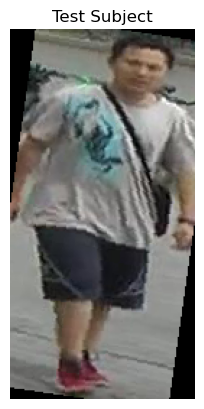

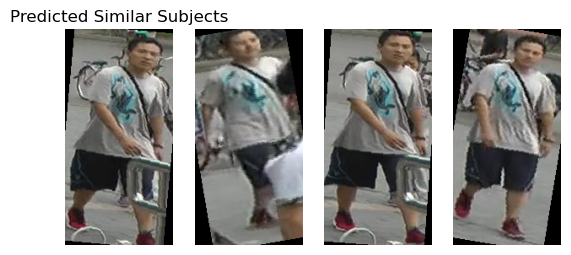

102


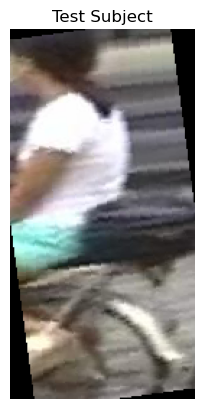

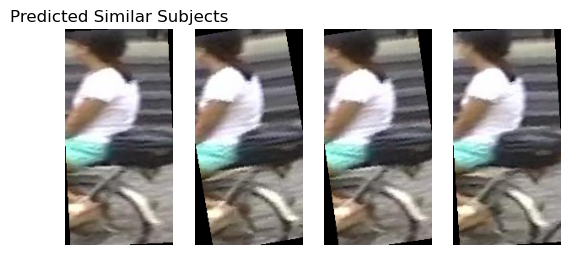

103


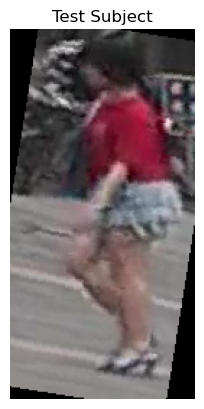

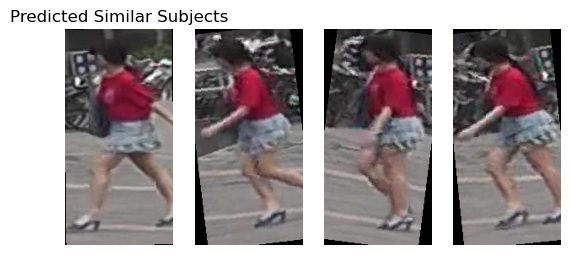

In [ ]:
for i in np.random.randint(1,len(test_dataset),size=3):
    test_img,_,_,_ = test_dataset[i]
    display_similar_images(model,test_img)